## **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import *
import os
import math

## **Data Loading and Preprocessing**

In [2]:
from sklearn.datasets import fetch_openml

# Step 1: Load the full MNIST dataset (70,000 images)
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
x, y = mnist["data"], mnist["target"].astype(int)

In [3]:
x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

## **Normalisation**

In [4]:
x = x/255.0

In [5]:
print("Digit Labels are : ", np.unique(y))

Digit Labels are :  [0 1 2 3 4 5 6 7 8 9]


In [6]:
# one hot encoding
encoder = OneHotEncoder(sparse_output = False)
y = encoder.fit_transform(y.reshape(-1,1))

In [7]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [9]:
print("Shape of X_trian : ",x_train.shape)
print("Shape of Y_trian : ",y_train.shape)
print("Shape of X_test : ",x_test.shape)
print("Shape of Y_test : ",y_test.shape)

Shape of X_trian :  (56000, 784)
Shape of Y_trian :  (56000, 10)
Shape of X_test :  (14000, 784)
Shape of Y_test :  (14000, 10)


## **Visualisation**

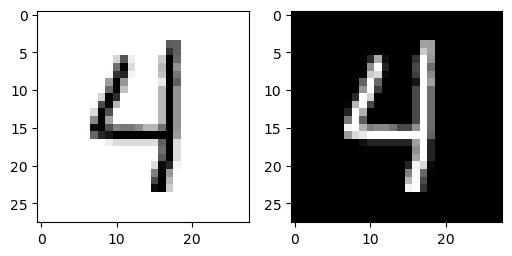

In [10]:
plt.figure(figsize=(6,6))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(x_train[7].reshape(28,28),cmap=plt.cm.binary)
ax2.imshow(x_train[7].reshape(28,28),cmap='gray')
plt.show()

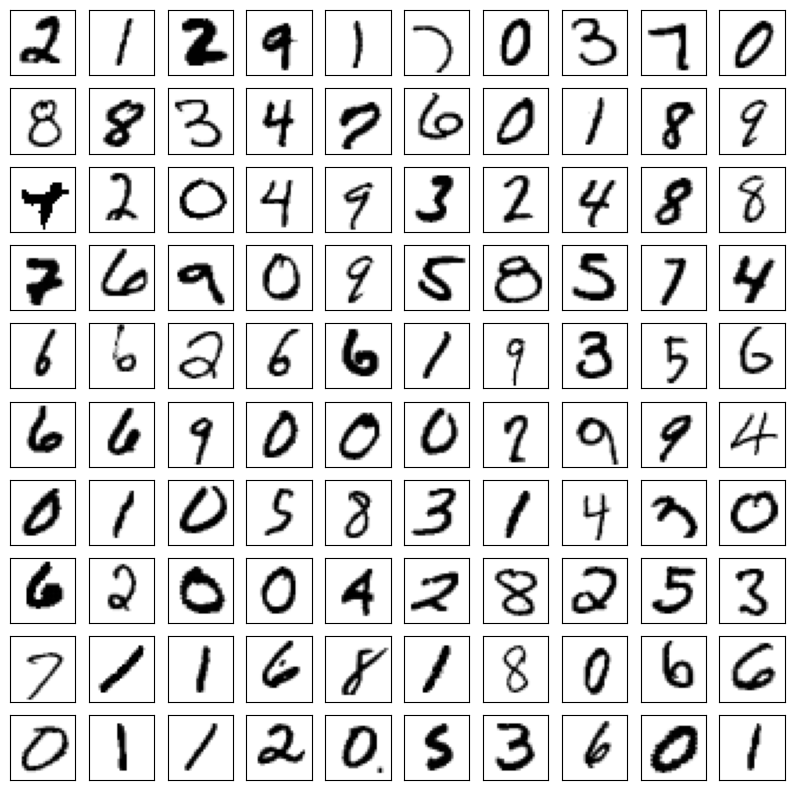

In [11]:
n = np.random.randint(0,x_train.shape[0],100) # 100 random no. from training dataset size

num_cells = math.ceil(math.sqrt(len(n))) # sqrt of 100 i.e 10

plt.figure(figsize=(10,10))

for i in range(len(n)):
  plt.subplot(num_cells,num_cells,i+1)
  plt.imshow(x_train[n[i]].reshape(28,28),cmap=plt.cm.binary)
  plt.xticks([])  # remove x ticks
  plt.yticks([])

plt.show()

In [12]:
x_train.min(), x_train.max()

(0.0, 1.0)

## **Model Building**

In [38]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate, epochs):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs

        """
        INPUT LAYER TO HIDDEN LAYER
        W1 = Input Layer Weight initialized for hidden layer
        b1 = initialized bias for hidden layer
        """
        self.W1 = np.random.randn(self.input_size, self.hidden_size)*0.01
        self.b1 = np.zeros((1, self.hidden_size))

        """
        HIDDEN LAYER TO OUTPUT LAYER
        W2 = Random weights from hidden layer to output layer
        b2 = bias for output layer
        """
        self.W2 = np.random.randn(self.hidden_size, self.output_size)*0.01
        self.b2 = np.zeros((1, self.output_size))

        """
        LOSS HISTORY and ACCURACY HISTORY for plotting and evaluation
        """
        self.loss_history = []
        self.accuracy_history = []

    """
    ACTIVATION FUNCTION
    ReLU function for Forward Propagation
    Derivative of ReLU for Back Propagation
    Softmax for Output Layer (Classification)
    """
    def relu(self,z):
        return np.maximum(0,z)

    def relu_derivative(self,z):
        return np.where(z>0,1,0)

    def softmax(self,z):
        exp_values = np.exp(z - np.max(z, axis = 1, keepdims = True))
        return exp_values/np.sum(exp_values,axis = 1, keepdims = True)

    """
    FORWARD PROPAGATION
    INPUT LAYER --> HIDDEN LAYER --> OUTPUT LAYER --> LOSS COMPUTATION
    """
    def forward(self,x):
        """
        INPUT LAYER TO HIDDEN LAYER
        computes the activated value in the hidden layer using ReLU function
        z1 = input with weight and bias
        a1 = activated value of z1
        """
        self.z1 = np.dot(x, self.W1) + self.b1
        self.a1 = self.relu(self.z1)

        """
        HIDDEN LAYER TO OUTPUT LAYER
        computes the probabilities using softmax for milti-class classification
        z2 = hidden layer output with weight and bias
        probs = prediction probabilities for each class
        """
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.probs = self.softmax(self.z2)
        return self.probs
    
    """
    LOSS COMPUTATION
    compute_loss = cross-entropy loss for multiclass classification
    compute_accuracy = Accuracy of the model
    """
    def compute_loss(self, y_true, probs):
        epsilon = 1e-15
        loss = -np.mean(np.sum(y_true * np.log(probs + epsilon), axis=1))
        return loss

    def compute_accuracy(self, y_true, probs):
        predictions = np.argmax(probs, axis = 1)
        true_labels = np.argmax(y_true, axis = 1)
        return np.mean(predictions == true_labels)

    """
    BACK PROPAGATION
    """
    def backward(self,x,y):
        m = x.shape[0]

        """
        Gradients of the loss w.r.t weights and biases of the output layer
        delta3 = Error at output layer 
        dW2 = Gradient of the loss w.r.t. weights of the output layer
        db2	= Gradient of the loss w.r.t. biases of the output layer
        """
        delta3 = self.probs - y
        dW2 = np.dot(self.a1.T, delta3)/m
        db2 = np.sum(delta3, axis = 0, keepdims = True)/m

        """
        Gradients of the loss w.r.t weights and biases of the Hidden layer
        delta2 = Error at hidden layer 
        dW1 = Gradient of the loss w.r.t. weights of the hidden layer
        db1	= Gradient of the loss w.r.t. biases of the hidden layer
        """
        delta2 = np.dot(delta3, self.W2.T)*self.relu_derivative(self.z1)
        dW1 = np.dot(x.T, delta2)/m
        db1 = np.sum(delta2, axis = 0, keepdims = True)/m

        """
        Update the parameters weights and biases across the layers
        """
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1

    """
    TRAINING THE MODEL
    """
    def train(self, x, y):
        for epoch in range(1,self.epochs+1):

            # Forward Pass
            probs = self.forward(x)

            # Compute the categorical cross-entropy loss
            loss = self.compute_loss(y, probs)
            accuracy = self.compute_accuracy(y,probs)
            self.loss_history.append(loss)
            self.accuracy_history.append(accuracy)

            # Backward pass
            self.backward(x, y)

            # Print the progress after every 10 epochs
            if epoch % 10 == 0:
                print(f'Epoch : {epoch}, Loss : {loss:.4f}, Accuracy : {accuracy:.4f}')

    """
    Testing
    """
    def test(self, x_test, y_test):
        probs = self.forward(x_test)
        loss = self.compute_loss(y_test, probs)
        accuracy = self.compute_accuracy(y_test, probs)
        print(f'Test Loss : {loss:.4f}, Test Accuracy : {accuracy:.4f}')
        return loss, accuracy 

## **Model Training**

In [39]:
# for the iris dataset
input_size = 784
hidden_size = 256 # 2*input size is max we generally take
output_size = 10

In [40]:
nn = NeuralNetwork(input_size, hidden_size, output_size, learning_rate = 0.1, epochs = 500)

In [41]:
nn

In [42]:
nn.train(x_train, y_train)

Epoch : 10, Loss : 2.2799, Accuracy : 0.5242
Epoch : 20, Loss : 2.2376, Accuracy : 0.5939
Epoch : 30, Loss : 2.1538, Accuracy : 0.5985
Epoch : 40, Loss : 2.0011, Accuracy : 0.6517
Epoch : 50, Loss : 1.7689, Accuracy : 0.7018
Epoch : 60, Loss : 1.4940, Accuracy : 0.7230
Epoch : 70, Loss : 1.2449, Accuracy : 0.7512
Epoch : 80, Loss : 1.0549, Accuracy : 0.7812
Epoch : 90, Loss : 0.9172, Accuracy : 0.8014
Epoch : 100, Loss : 0.8165, Accuracy : 0.8157
Epoch : 110, Loss : 0.7410, Accuracy : 0.8271
Epoch : 120, Loss : 0.6830, Accuracy : 0.8370
Epoch : 130, Loss : 0.6371, Accuracy : 0.8453
Epoch : 140, Loss : 0.6000, Accuracy : 0.8525
Epoch : 150, Loss : 0.5695, Accuracy : 0.8579
Epoch : 160, Loss : 0.5438, Accuracy : 0.8635
Epoch : 170, Loss : 0.5219, Accuracy : 0.8674
Epoch : 180, Loss : 0.5030, Accuracy : 0.8704
Epoch : 190, Loss : 0.4865, Accuracy : 0.8740
Epoch : 200, Loss : 0.4721, Accuracy : 0.8768
Epoch : 210, Loss : 0.4593, Accuracy : 0.8795
Epoch : 220, Loss : 0.4479, Accuracy : 0.88

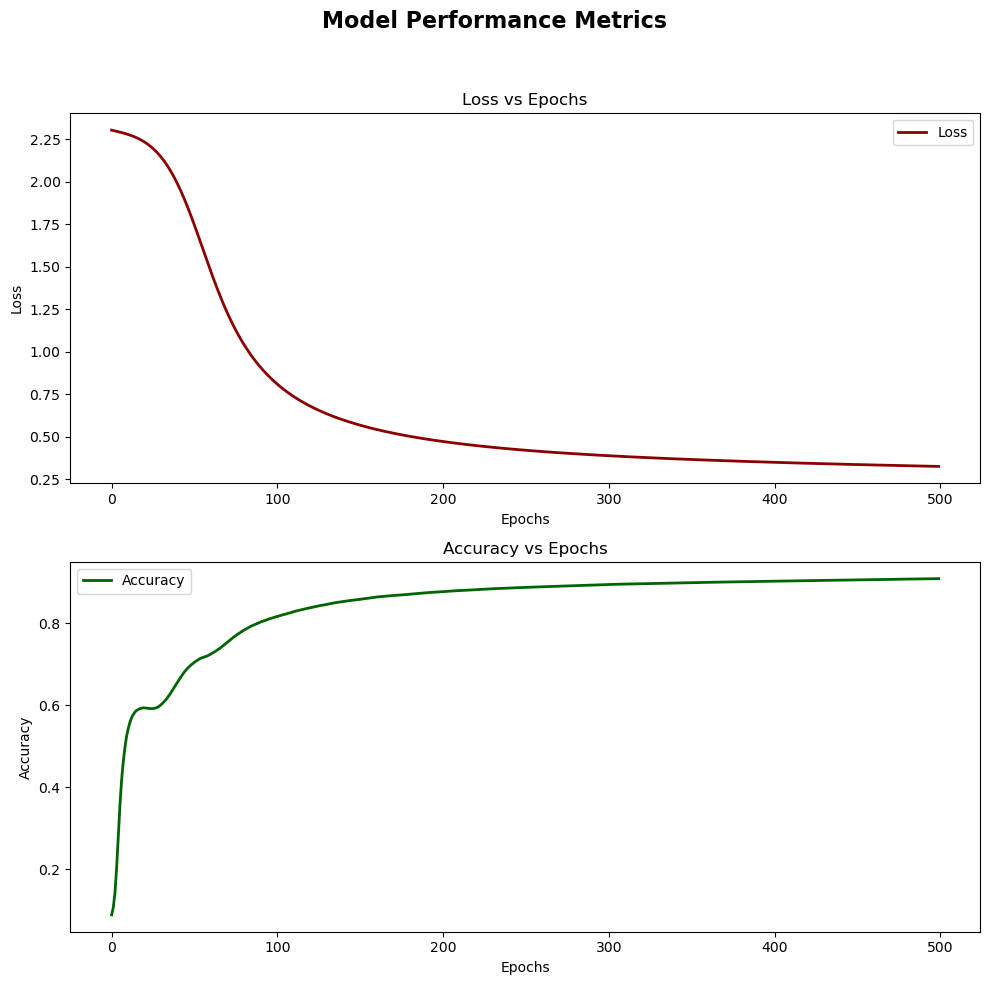

In [43]:
fig, ax = plt.subplots(2,1, figsize = (10,10))

### Plot the loss by epoch
ax[0].plot(nn.loss_history, label='Loss', color='darkred', linewidth=2)
ax[0].set_title('Loss vs Epochs')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()


### Plot the accuracy by epoch
ax[1].plot(nn.accuracy_history, label='Accuracy', color='darkgreen', linewidth=2)
ax[1].set_title('Accuracy vs Epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

### Add a super title
plt.suptitle('Model Performance Metrics', fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the super title

plt.show()

## **Using Sklearn neural network model**

In [29]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(128,), max_iter=100, random_state=42, verbose=True)
mlp.fit(x_train, y_train) 

Iteration 1, loss = 1.21239792
Iteration 2, loss = 0.53997706
Iteration 3, loss = 0.41354835
Iteration 4, loss = 0.34219325
Iteration 5, loss = 0.29258559
Iteration 6, loss = 0.25437679
Iteration 7, loss = 0.22422116
Iteration 8, loss = 0.20145431
Iteration 9, loss = 0.18081056
Iteration 10, loss = 0.16297131
Iteration 11, loss = 0.14845034
Iteration 12, loss = 0.13568175
Iteration 13, loss = 0.12518706
Iteration 14, loss = 0.11437954
Iteration 15, loss = 0.10518245
Iteration 16, loss = 0.09724544
Iteration 17, loss = 0.08981918
Iteration 18, loss = 0.08358076
Iteration 19, loss = 0.07654108
Iteration 20, loss = 0.07072636
Iteration 21, loss = 0.06474389
Iteration 22, loss = 0.06047668
Iteration 23, loss = 0.05585809
Iteration 24, loss = 0.05162051
Iteration 25, loss = 0.04706170
Iteration 26, loss = 0.04395446
Iteration 27, loss = 0.04041381
Iteration 28, loss = 0.03678519
Iteration 29, loss = 0.03298499
Iteration 30, loss = 0.03063411
Iteration 31, loss = 0.02798892
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(128,), max_iter=100, random_state=42,
              verbose=True)

In [30]:
mlp.predict_proba(x_test)

array([[2.70743284e-24, 6.69711856e-22, 1.88851060e-12, ...,
        6.15823473e-18, 1.00000000e+00, 4.58289154e-33],
       [1.23160974e-25, 2.78799053e-22, 3.03255442e-26, ...,
        4.22783287e-08, 5.45500541e-19, 4.20604002e-18],
       [5.36970530e-13, 1.05216563e-17, 5.48189113e-12, ...,
        2.10827447e-15, 9.99867169e-01, 3.75240908e-10],
       ...,
       [9.39900460e-11, 9.80359154e-11, 9.99999778e-01, ...,
        2.05458956e-14, 1.65955959e-10, 1.10159716e-15],
       [4.58179862e-23, 8.07481142e-18, 4.69217345e-15, ...,
        9.99999997e-01, 5.72628414e-16, 6.54778678e-09],
       [2.95297900e-11, 9.99999992e-01, 1.92171284e-12, ...,
        3.39208434e-04, 6.27985180e-09, 6.60012594e-14]])

In [31]:
mlp.predict(x_test)

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [32]:
mlp.score(x_test, y_test)

0.9478571428571428